In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
pybn_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/pyBN-master'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
if pybn_dir not in sys.path:
    sys.path.append(pybn_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from latent_nce_optimiser import LatentNCEOptimiser, CDOptimiser
from latent_variable_model import RestrictedBoltzmannMachine
from utils import get_true_weights

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# Setup

#### data

In [3]:
n = 10000 # number of datapoints
nz = 5  # number latent samples per datapoint
nu = 1  # ratio of noise to data samples for NCE
num_gibbs_steps_for_synthetic_data = 200

#### model

In [4]:
d = 20  # visible dimension
m = 15  # latent dimension

# true_W = get_true_weights(d, m)
true_W = rnd.randn(d+1, m+1)*0.5 # true setting of the weights, that we are trying to learn
true_W[0, 0] = 0

# theta0 = np.array(true_W)
theta0 = rnd.randn(d+1, m+1)*0.01  # random initialisation of weights
theta0[0, 0] = -np.log(2) * (d + m)

#### optimisation

In [5]:
# tolerances used to determine when iterations stop in scipy minimize (used in LatentNCEOptimiser)
gtol = 1e-4
ftol = 1e-4
# threshold for stopping EM outer loop of optimisation in LatentNCEOptimiser
stop_threshold =  1e-02
# maximum number of EM steps
max_num_em_steps = 20

# hyperparameters used in CDOptimiser (contrastive divergence optimiser)
cd_num_steps = 1
cd_learn_rate = 0.001
cd_batch_size = 10

#### boolean switches

In [6]:
init_scaling_param_at_data_dist_scale = False
init_scaling_param_at_rnd_init_scale = False
init_visible_biases_with_entropy = False

optimise_scaling_param_separately = False

use_chow_liu = False
use_marginals = True

assert use_chow_liu != use_marginals
assert not( init_scaling_param_at_data_dist_scale and init_scaling_param_at_rnd_init_scale)

# Data, Model & Optimiser definition

#### sample a synthetic dataset

In [7]:
%%time
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=num_gibbs_steps_for_synthetic_data)

CPU times: user 2.1 s, sys: 180 ms, total: 2.28 s
Wall time: 2.26 s


In [8]:
# initialise visible biases as recommended by Hinton
X_mean = np.mean(X, axis=0)
if init_visible_biases_with_entropy:
    theta0[1:, 0] = np.log(X_mean / (1 - X_mean))

#### initialise three models for comparison

In [9]:
model = RestrictedBoltzmannMachine(theta0)
cd_model = RestrictedBoltzmannMachine(theta0)
random_init_model = RestrictedBoltzmannMachine(theta0)

#### Specify noise distribution

In [10]:
if use_chow_liu:
    noise = ChowLiuTree(X)
if use_marginals:
    noise = MultivariateBernoulliNoise(X_mean)

In [11]:
marginal_noise = MultivariateBernoulliNoise(X_mean)
chow_liu_noise = ChowLiuTree(X)
print('log likelihood of chow liu-tree noise: {}'.format(np.mean(np.log(chow_liu_noise(X)))))
print('log likelihood of marginal noise: {}'.format(np.mean(np.log(marginal_noise(X)))))
print('average prob of data under chow liu-tree noise: {}'.format(np.mean(chow_liu_noise(X))))
print('average prob of data under marginal noise: {}'.format(np.mean(marginal_noise(X))))

log likelihood of chow liu-tree noise: -9.319495281118265
log likelihood of marginal noise: -9.358151523745173
average prob of data under chow liu-tree noise: 0.0004146531134653978
average prob of data under marginal noise: 0.00038685530632096536


#### specify exact posterior distribution

In [12]:
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

#### construct optimiser

In [13]:
%%time
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(cd_model)

CPU times: user 2.14 ms, sys: 924 µs, total: 3.06 ms
Wall time: 2.44 ms


#### log of true normalisation constant

In [14]:
true_data_dist.reset_norm_const()
true_norm_const = true_data_dist.norm_const
true_W[0, 0] = -np.log(true_norm_const)
print('{:.4f}'.format(-np.log(true_norm_const)))

-35.6896


#### log of normalising constant for random initialisation

In [15]:
random_init_model.reset_norm_const()
rnd_norm_const = random_init_model.norm_const
print('{:.4f}'.format(np.log((np.exp(theta0[0,0])*rnd_norm_const))))

-24.2339


#### starting value of scaling parameter

In [16]:
print(theta0[0,0])

-24.260151319598084


# Optimisation

In [17]:
if init_scaling_param_at_data_dist_scale:
    theta0[0, 0] = -np.log(true_norm_const)
if init_scaling_param_at_rnd_init_scale:
    theta0[0, 0] = -np.log(rnd_norm_const)

In [18]:
scaling_param_ind = np.array([0])
other_param_inds = np.arange(1, len(model.theta))
all_inds = np.arange(len(model.theta))

#### optimise with respect to scaling parameter, if switch is on

In [19]:
%%time
if optimise_scaling_param_separately:
    thetas_after_em_step_scale_param, J1s_scale, J1_grads_scale = optimiser.fit_using_analytic_q(X, 
                                                                                     scaling_param_ind, 
                                                                                     theta0=theta0.reshape(-1), 
                                                                                     stop_threshold=stop_threshold, 
                                                                                     max_num_em_steps=max_num_em_steps,
                                                                                     gtol=gtol, 
                                                                                     ftol=ftol, 
                                                                                     plot=False, 
                                                                                     disp=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 10.5 µs


In [20]:
if optimise_scaling_param_separately:
    fig, ax = optimiser.plot_loss_curve(J1s_scale, plot_reset_points=False, true_theta = true_W.reshape(-1), X=X)

#### optimise with respect to all parameters

In [21]:
%%time
thetas_after_em_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, 
                                                                     theta0=model.theta,
                                                                     disp=True,
                                                                     stop_threshold=stop_threshold, 
                                                                     max_num_em_steps=max_num_em_steps,
                                                                     gtol=gtol, 
                                                                     ftol=ftol, 
                                                                     plot=False)
latent_nce_estimate = model.theta

/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/latent_nce_optimiser.py:286: OptimizeWarning: Unknown solver options: ftol
  options={'gtol': gtol, 'ftol': ftol, 'disp': disp})


         Current function value: 1.389302
         Iterations: 82
         Function evaluations: 181
         Gradient evaluations: 170


/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/latent_nce_optimiser.py:286: OptimizeWarning: Unknown solver options: ftol
  options={'gtol': gtol, 'ftol': ftol, 'disp': disp})


         Current function value: 1.379721
         Iterations: 69
         Function evaluations: 153
         Gradient evaluations: 141
CPU times: user 1min 17s, sys: 14.2 s, total: 1min 31s
Wall time: 1min 31s


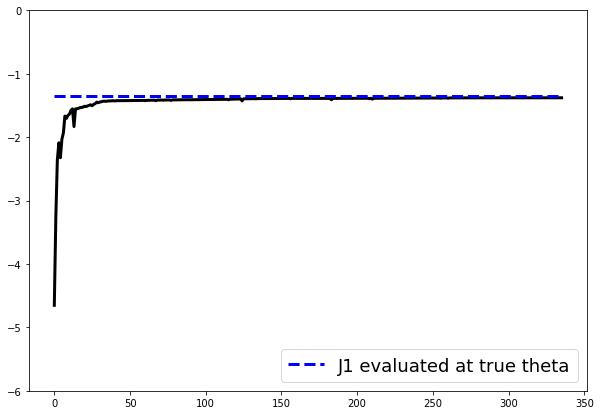

In [22]:
fig, ax = optimiser.plot_loss_curve(J1s, plot_reset_points=False, endpoints=None, 
                                    true_theta = true_W.reshape(-1), X=X)

In [23]:
J1_len = sum([len(i) for i in J1s])
#fig, ax = optimiser.plot_loss_curve(J1s, endpoints=(5, J1_len), true_theta = true_W.reshape(-1), X=X)

#### learn parameters using contrastive divergence

In [24]:
%%time
thetas_after_each_minibatch = cd_optimiser.fit(X, theta0=theta0.reshape(-1), num_gibbs_steps=cd_num_steps,
                                               learning_rate=cd_learn_rate, batch_size=cd_batch_size)
cd_estimate =  cd_model.theta

CPU times: user 1.76 s, sys: 20 ms, total: 1.78 s
Wall time: 1.76 s


# Results

## Log-likelihood on training set

### $ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [25]:
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
cd_probs_of_true_data, _ = cd_model.normalised_and_marginalised_over_z(X)
random_probs_of_true_data, _ = random_init_model.normalised_and_marginalised_over_z(X)
print('True:       {:.4f} \nLatent NCE: {:.4f} \nCD:         {:.4f}\nRandom init:{:.4f} \nNoise:      {:.4f}'.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data)),
    np.mean(np.log(noise(X)))
))

True:       -9.2962 
Latent NCE: -9.3476 
CD:         -9.3591
Random init:-13.8227 
Noise:      -9.3582


## Frobenius norm of true parameters minus model parameters

In [26]:
# NOTE: we exclude the scaling parameter in all comparisons

random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5
nce_true_param_diff = (true_W - latent_nce_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5
cd_true_param_diff = (true_W - cd_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5
nce_cd_param_diff = (latent_nce_estimate - cd_estimate)[1:]
sq_diff_nce_cd = np.dot(nce_cd_param_diff, nce_cd_param_diff)**0.5
print('true vs latent nce:   {:.4f}'.format(sq_diff_nce_true))
print('true vs cd:           {:.4f}'.format(sq_diff_cd_true))
print('true vs random init:  {:.4f}'.format(sq_diff_rand_true))
print('nce vs cd:            {:.4f}'.format(sq_diff_nce_cd))

true vs latent nce:   9.7960
true vs cd:           8.9342
true vs random init:  9.3227
nce vs cd:            4.0893


### Scaling parameter

In [27]:
print('Learnt Scaling param is:              {:.4f}'.format(latent_nce_estimate[0]))
print('log of norm const of data distribution is:   {:.4f}'.format(-np.log(true_norm_const)))

Learnt Scaling param is:              -26.0415
log of norm const of data distribution is:   -35.6896


In [28]:
model.reset_norm_const()
print('We hope that the normalisation constant of the learnt model is 1. In reality it is: {} '.format(
    model.norm_const))

We hope that the normalisation constant of the learnt model is 1. In reality it is: 1.0054407593098804 


## Visualisations of parameters

In [61]:
def plot_parameters(params, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs = axs.ravel()
    axs[0].imshow(params, cmap='Blues')
    axs[1].imshow(params[1:, 1:], cmap='Blues')
    axs[0].set_title('with biases', fontsize=16)
    axs[1].set_title('without biases', fontsize=16)
    axs[0].set_xlabel('visible weights', fontsize=16)
    axs[0].set_ylabel('hidden weights', fontsize=16)
    axs[1].set_xlabel('visible weights', fontsize=16)
    axs[1].set_ylabel('hidden weights', fontsize=16)
    fig.suptitle('{}'.format(title), fontsize=20)
    #plt.tight_layout()

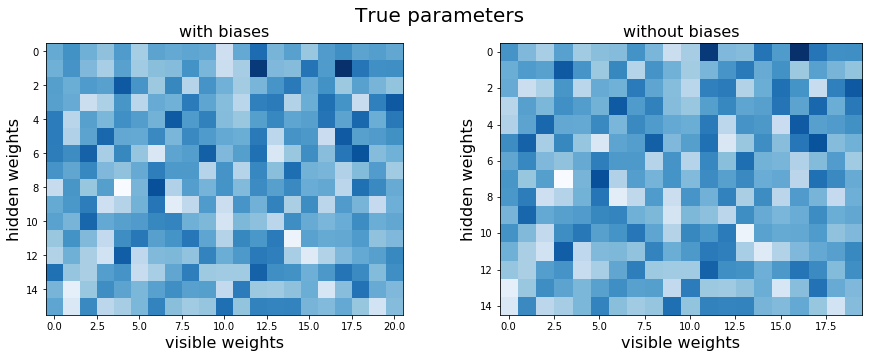

In [62]:
true_params = np.array(true_data_dist.theta.reshape(d+1, m+1).T)
true_params[0,0] = 0
plot_parameters(true_params, 'True parameters')

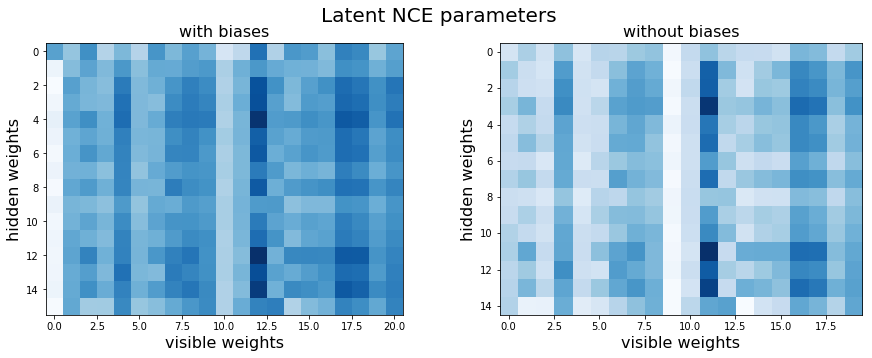

In [63]:
nce_params = np.array(model.theta.reshape(d+1, m+1).T)
nce_params[0,0] = 0
plot_parameters(nce_params, 'Latent NCE parameters')

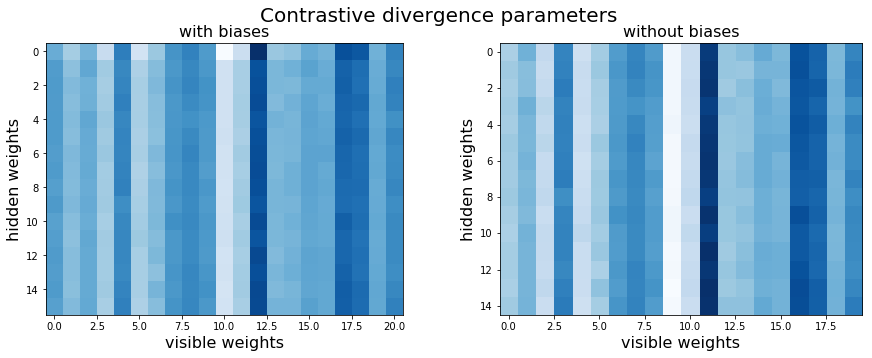

In [64]:
cd_params = np.array(cd_model.theta.reshape(d+1, m+1).T)
cd_params[0,0] = 0
plot_parameters(cd_params, 'Contrastive divergence parameters')

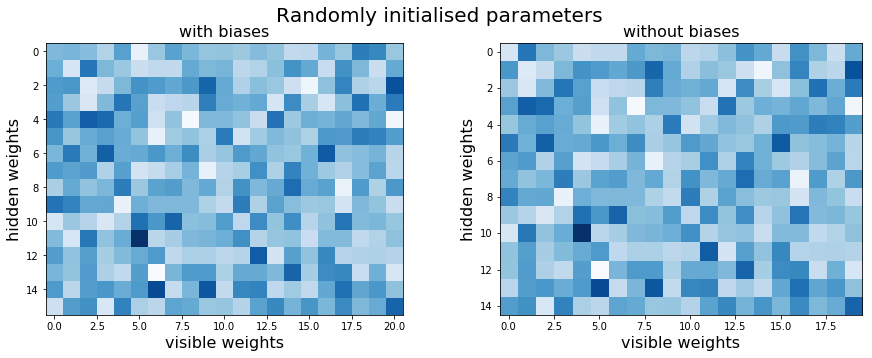

In [66]:
rnd_params = np.array(random_init_model.theta.reshape(d+1, m+1).T)
rnd_params[0,0] = 0
plot_parameters(rnd_params, 'Randomly initialised parameters')

#### values of hidden biases

In [33]:
print('true hidden bias: {} \nnce hidden bias:  {} '
      '\ncd_hidden bias:   {} \nrnd_hidden bias:   {}'.format(true_params[1:,0], 
                                                              nce_params[1:, 0],
                                                              cd_params[1:, 0], 
                                                              rnd_params[1:, 0]))

true hidden bias: [-0.09 0.15 0.13 0.58 0.59 0.57 0.29 -0.85 0.01 0.11 -0.41 -0.64 0.74
 -0.14 0.06] 
nce hidden bias:  [-0.83 -0.91 -0.86 -0.78 -0.82 -0.88 -0.82 -0.90 -0.81 -0.87 -0.84 -0.86
 -0.85 -0.83 -0.91] 
cd_hidden bias:   [0.06 0.07 0.07 0.07 0.07 0.06 0.07 0.05 0.07 0.05 0.06 0.07 0.06 0.07
 0.05] 
rnd_hidden bias:   [0.00 0.01 0.01 0.02 0.01 0.00 0.01 -0.01 0.02 -0.02 -0.00 0.01 0.00 0.01
 -0.01]


#### values of visible biases

In [34]:
print('true hidden bias: {} \nnce hidden bias:  {} '
      '\ncd_hidden bias:   {} \nrnd_hidden bias:   {}'.format(true_params[0, 1:], 
                                                              nce_params[0, 1:],
                                                              cd_params[0, 1:], 
                                                              rnd_params[0, 1:]))

true hidden bias: [0.33 -0.09 -0.33 0.21 -0.51 0.08 0.01 0.07 0.03 -0.94 0.01 0.78 -0.14
 0.13 -0.40 0.20 0.36 0.09 0.16 0.03] 
nce hidden bias:  [-0.26 0.12 -0.41 -0.17 -0.42 0.08 -0.17 0.01 -0.13 -0.64 -0.47 0.31 -0.39
 0.07 0.03 -0.22 0.21 0.16 -0.28 -0.02] 
cd_hidden bias:   [-0.14 -0.03 -0.24 0.17 -0.29 -0.11 0.09 0.16 0.07 -0.46 -0.25 0.45 -0.11
 -0.09 0.01 -0.02 0.34 0.31 -0.02 0.15] 
rnd_hidden bias:   [0.00 -0.00 -0.01 0.01 -0.02 -0.00 0.01 0.00 -0.00 -0.00 -0.00 -0.00 -0.00
 -0.01 -0.01 0.00 -0.00 0.01 0.01 -0.00]


#### values of weights (not including biases)

In [35]:
print(nce_params[1:,1:])

[[-0.20 -0.02 -0.18 0.07 -0.22 -0.07 -0.07 0.03 0.06 -0.37 -0.11 0.06
  -0.07 -0.12 -0.12 -0.18 0.12 0.10 -0.11 0.01]
 [0.00 -0.15 -0.21 0.25 -0.18 -0.11 0.08 0.22 0.15 -0.39 -0.15 0.51 0.11
  -0.17 0.01 0.12 0.35 0.28 0.11 0.29]
 [-0.07 -0.16 -0.17 0.31 -0.17 -0.20 0.15 0.25 0.18 -0.36 -0.10 0.52 0.01
  -0.19 0.04 0.02 0.37 0.33 0.13 0.24]
 [-0.01 0.13 -0.12 0.34 -0.17 -0.08 0.23 0.26 0.25 -0.38 -0.15 0.70 0.03
  0.05 0.13 0.08 0.47 0.43 0.08 0.30]
 [-0.12 -0.03 -0.11 0.21 -0.16 -0.15 0.13 0.20 0.11 -0.33 -0.14 0.42
  -0.01 -0.08 0.04 0.05 0.34 0.27 -0.02 0.14]
 [-0.10 0.09 -0.05 0.20 -0.18 -0.14 0.19 0.19 0.06 -0.37 -0.16 0.47 -0.10
  -0.01 0.08 0.05 0.34 0.31 0.01 0.14]
 [-0.12 -0.11 -0.23 0.19 -0.25 -0.07 0.03 0.09 0.07 -0.35 -0.17 0.25 0.04
  -0.16 -0.11 -0.14 0.23 0.16 -0.10 0.08]
 [-0.05 0.04 -0.11 0.18 -0.14 -0.15 0.24 0.14 0.10 -0.39 -0.15 0.46 -0.10
  0.04 0.09 0.13 0.31 0.30 0.09 0.18]
 [-0.15 -0.17 -0.23 0.05 -0.26 -0.07 -0.09 0.05 0.01 -0.35 -0.14 0.04
  0.05 -0.23 -0.17 -

## Histograms of posterior distribution during learning

In [36]:
thetas = []
if optimise_scaling_param_separately:
    thetas = list(thetas_after_em_step_scale_param)
    thetas.extend(list(thetas_after_em_step))
else:
    thetas = list(thetas_after_em_step)

thetas = thetas[::10]
thetas.append(true_W.reshape(-1))
num_thetas = len(thetas)

In [37]:
if m <= 5:    
    all_latents = model.get_all_binary_vectors(m)
    all_latents_tiled = np.repeat(all_latents, len(X)).reshape(len(all_latents), len(X), m)
    fig, axs = plt.subplots(int(np.ceil(num_thetas/4)), 4, figsize=(15, 7))
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        if i == num_thetas:
            break
        theta_i = thetas[i]
        var_dist.alpha = theta_i.reshape(-1)
        var_dist_probs = var_dist(all_latents_tiled, X)
        ax.hist(var_dist_probs.reshape(-1), bins=int(0.1*var_dist_probs.size**0.5))
        ax.set_yticks([])

## L1 norm between model joint & true joint

$$ \| \phi - p_{data} \|_1 = \sum_{\textbf{v} \in \{0,1\}^{d}} \sum_{\textbf{h} \in \{0,1\}^{m}} |\phi(\textbf{v}, \textbf{h}) - p_{data}(\textbf{v}, \textbf{h}) | $$

In [38]:
true_model_vals = true_data_dist.evaluate_on_entire_domain(normalise=True)
latent_nce_vals = model.evaluate_on_entire_domain(normalise=False)
cd_vals = cd_model.evaluate_on_entire_domain(normalise=True)
rnd_init_vals = random_init_model.evaluate_on_entire_domain(normalise=True)

l1_norm_diff_true_nce = np.sum(np.abs(true_model_vals - latent_nce_vals))
l1_norm_diff_true_cd = np.sum(np.abs(true_model_vals - cd_vals))
l1_norm_diff_true_rnd_init = np.sum(np.abs(true_model_vals - rnd_init_vals))

print('||true - latent nce||:   {:.4f}'.format(l1_norm_diff_true_nce))
print('||true - cd||:           {:.4f}'.format(l1_norm_diff_true_cd))
print('||true - random init||:  {:.4f}'.format(l1_norm_diff_true_rnd_init))

AssertionError: Evaluating over the whole domain has O(2**(m+d)) cost. Assertion raised since m+d is equal to 35, which exceeds the current limit of 20

### log-likelihood assigned to noise

In [39]:
print(
'Under noise dist:   {} '
'\nUnder true dist:    {} '
'\nUnder learnt model: {}'.format(
    np.mean(np.log(noise(optimiser.Y))), 
    np.mean(np.log(true_data_dist.normalised_and_marginalised_over_z(optimiser.Y)[0])),
    np.mean(np.log(model.normalised_and_marginalised_over_z(optimiser.Y)[0]))                  
    )
)

Under noise dist:   -9.339534196262155 
Under true dist:    -9.399712968065257 
Under learnt model: -9.349732978998789


# Validation of synthetic dataset

In [ ]:
"""all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))
print('normalisation constant is: {}'.format(true_dist_norm_const))

all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""